In [35]:
import pydicom
import numpy as np
import cv2
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab

from pylab import *
from scipy import *
from skimage import morphology

In [8]:
file_path = "/Users/s4pph173/Downloads/Images/ID_00008ce3c.dcm"

medical_image = pydicom.read_file(file_path)
print(medical_image)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9999.323963471261304362000778386798474522633
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_00008ce3c
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_ce8a3cd2'
(0020, 000d) Study Instance UID                  UI: ID_974735bf79
(0020, 000e) Series Instance UID                 UI: ID_3780d48b28
(0020, 0010) Study ID                            SH: ''
(0020, 00

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'ID_00008ce3c'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'ID_974735bf79'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'ID_3780d48b28'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


In [9]:
image = medical_image.pixel_array
print(image.shape)

(512, 512)


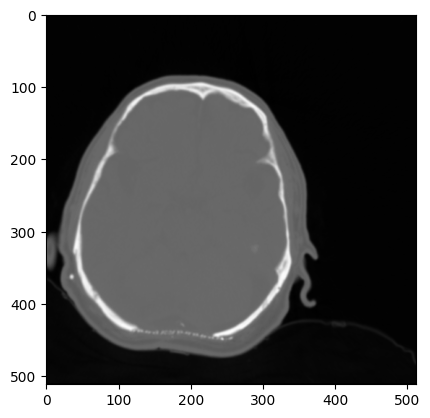

In [10]:
plt.imshow(image, cmap='gray')

In [11]:
print(image.min())
print(image.max())

0
2602


## Transform pixels to Hounsfield Units (HU)

In [12]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    
    return hu_image

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

## Remove noise (de-noising)

In [21]:
def remove_noise(file_path, display = False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80) #bone windowing
    
    segmentation = morphology.dilation(brain_image, np.ones((1,1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(int))
    label_count[0] = 0
    
    mask = labels == label_count.argmax()
    
    #improve brain mask
    mask = morphology.dilation(mask, np.ones((1,1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3,3)))
    masked_image = mask * brain_image
    
    if display:
        plt.figure(figsize=(15,2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')
        
        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final image')
        plt.axis('off')
    
    return masked_image

/var/folders/3f/kytck1fj5hn031d2mpt47y1c0000gn/T/ipykernel_7308/90494939.py:18: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  mask = ndimage.morphology.binary_fill_holes(mask)


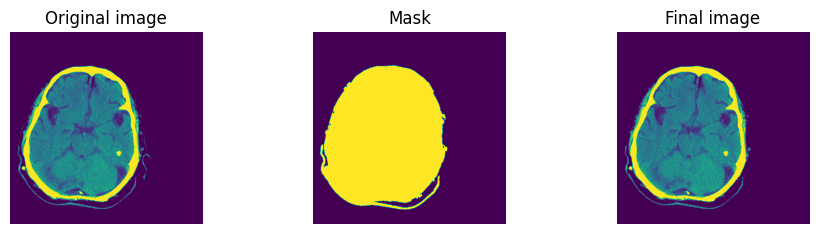

In [22]:
_ = remove_noise(file_path, display = True)

/var/folders/3f/kytck1fj5hn031d2mpt47y1c0000gn/T/ipykernel_7308/90494939.py:18: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  mask = ndimage.morphology.binary_fill_holes(mask)


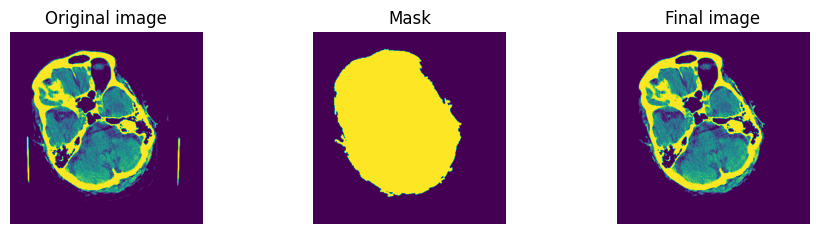

In [38]:
path2 = "/Users/s4pph173/Downloads/Images/ID_000012eaf.dcm"

masked_image2 = remove_noise(path2, display=True)

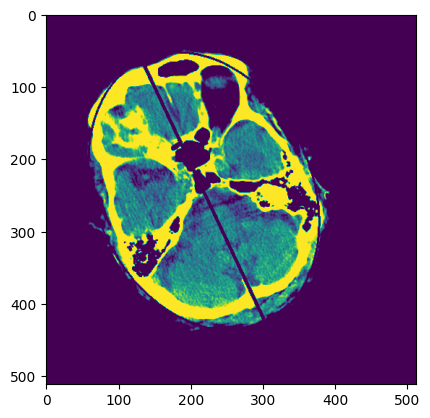

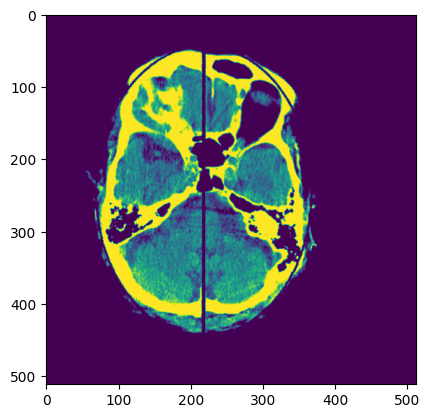

In [40]:
#Tilt correction

img=np.uint8(masked_image2)
contours, hier =cv2.findContours (img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask=np.zeros(img.shape, np.uint8)

# find the biggest contour (c) by the area
c = max(contours, key = cv2.contourArea)

(x,y),(MA,ma),angle = cv2.fitEllipse(c)

cv2.ellipse(img, ((x,y), (MA,ma), angle), color=(0, 255, 0), thickness=2)

rmajor = max(MA,ma)/2
if angle > 90:
    angle -= 90
else:
    angle += 90
xtop = x + math.cos(math.radians(angle))*rmajor
ytop = y + math.sin(math.radians(angle))*rmajor
xbot = x + math.cos(math.radians(angle+180))*rmajor
ybot = y + math.sin(math.radians(angle+180))*rmajor
cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

plt.imshow(img)
plt.show()

M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  #transformation matrix

img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

plt.imshow(img)
plt.show()

In [41]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    cropped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return cropped_image

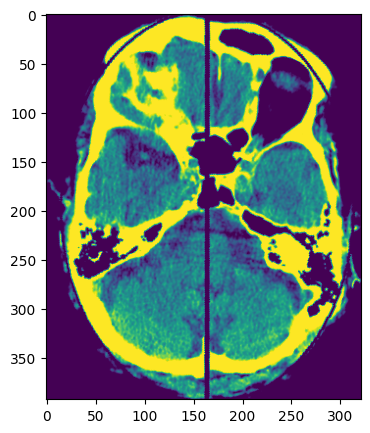

In [42]:
croppedImage = crop_image(img)

plt.figure(figsize=(15, 5))
plt.imshow(croppedImage)

In [43]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

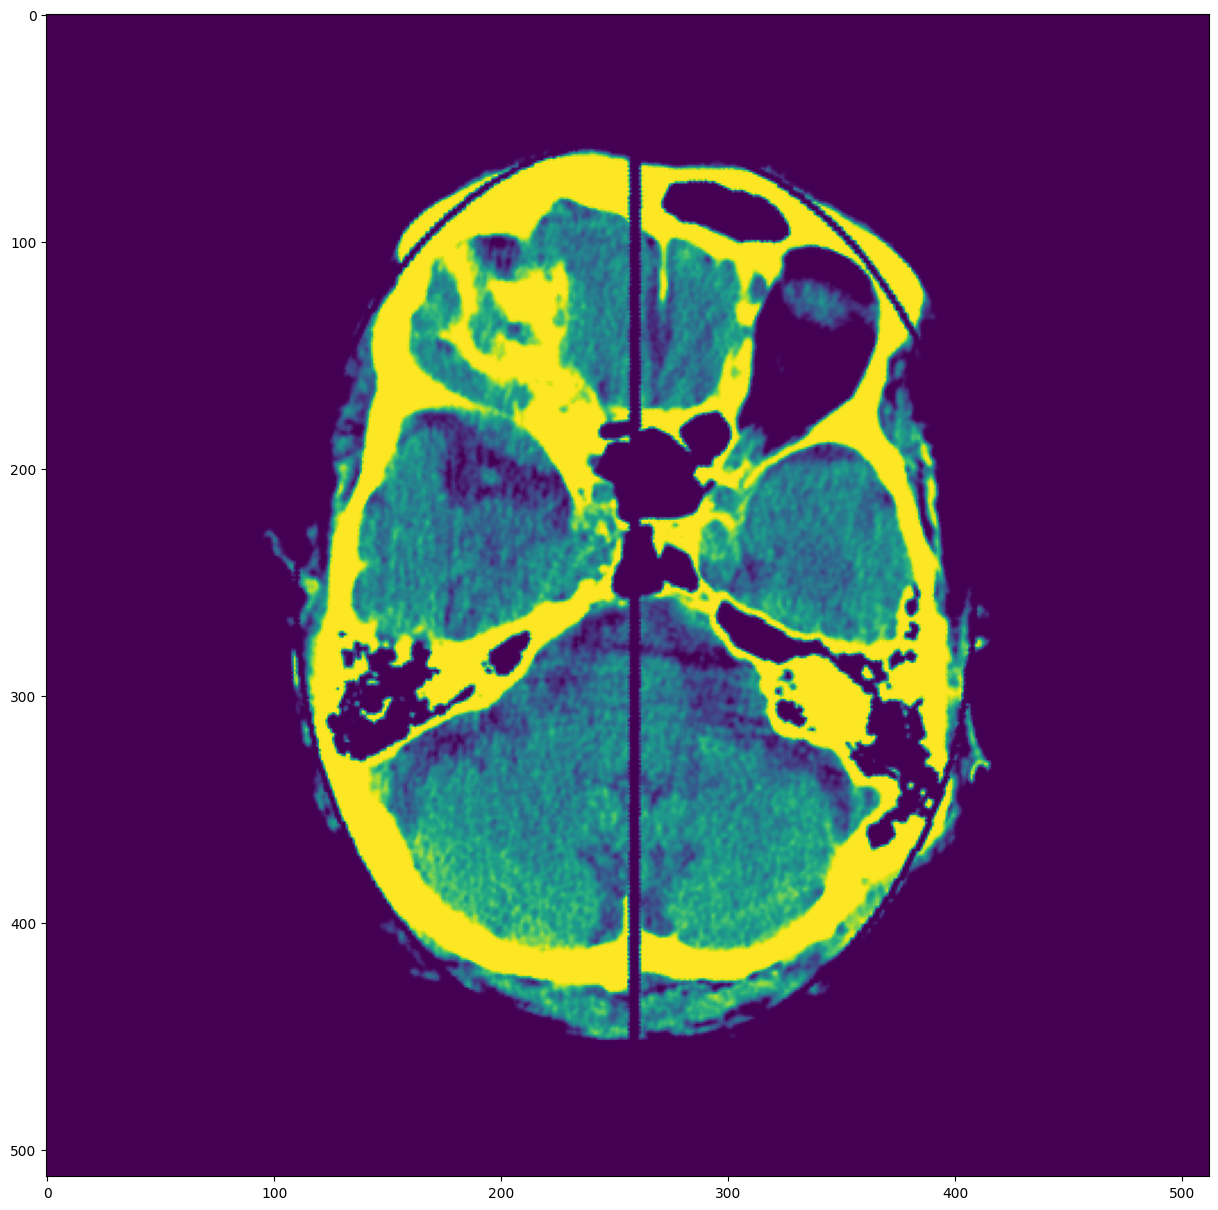

In [44]:
plt.figure(figsize=(15, 25))
final_image = add_pad(croppedImage)
plt.imshow(final_image)

In [45]:
new_name = "new_MR_2.png"
folder_name = "/Users/s4pph173/Downloads/Images/"
cv2.imwrite(os.path.join(folder_name,new_name),final_image*3)

True

/var/folders/3f/kytck1fj5hn031d2mpt47y1c0000gn/T/ipykernel_7308/90494939.py:18: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  mask = ndimage.morphology.binary_fill_holes(mask)


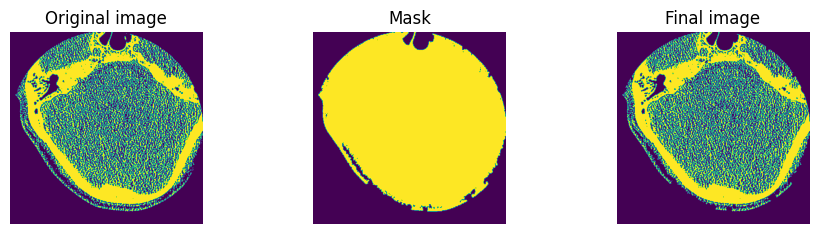

In [49]:
path3 = "/Users/s4pph173/Downloads/Images/10.dcm" #spinal disc

masked_image3 = remove_noise(path3, display = True)

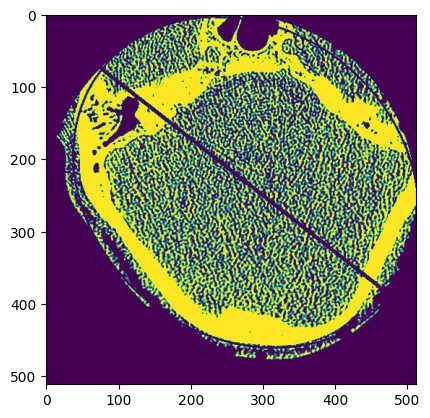

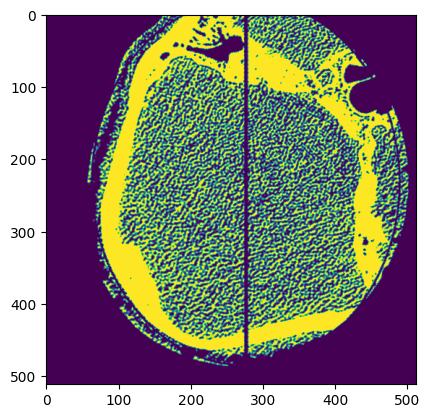

In [50]:
img=np.uint8(masked_image3)
contours, hier =cv2.findContours (img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask=np.zeros(img.shape, np.uint8)

# find the biggest contour (c) by the area
c = max(contours, key = cv2.contourArea)

(x,y),(MA,ma),angle = cv2.fitEllipse(c)

cv2.ellipse(img, ((x,y), (MA,ma), angle), color=(0, 255, 0), thickness=2)

rmajor = max(MA,ma)/2
if angle > 90:
    angle -= 90
else:
    angle += 90
xtop = x + math.cos(math.radians(angle))*rmajor
ytop = y + math.sin(math.radians(angle))*rmajor
xbot = x + math.cos(math.radians(angle+180))*rmajor
ybot = y + math.sin(math.radians(angle+180))*rmajor
cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

plt.imshow(img)
plt.show()

M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  #transformation matrix

img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

plt.imshow(img)
plt.show()

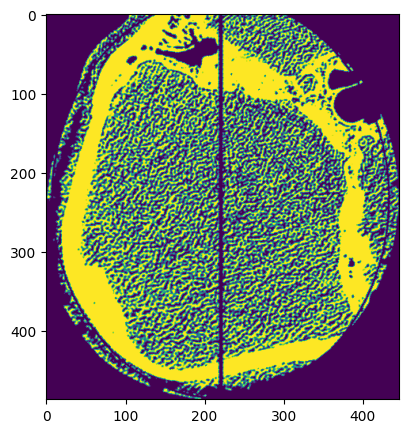

In [51]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    cropped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return cropped_image

croppedImage = crop_image(img)

plt.figure(figsize=(15, 5))
plt.imshow(croppedImage)

True

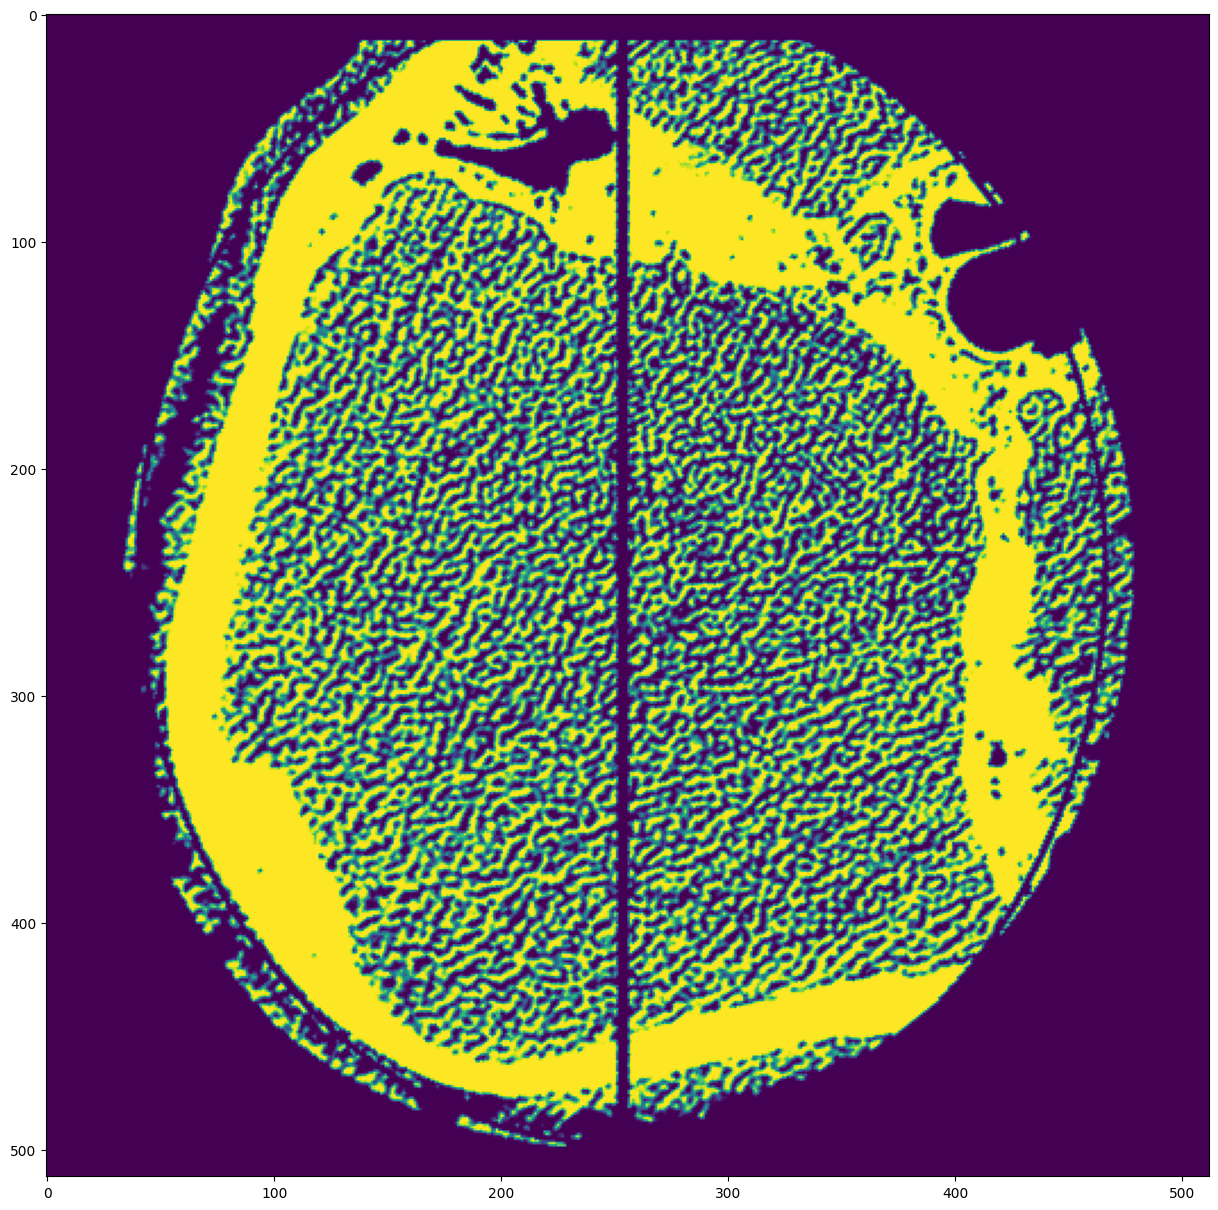

In [52]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

plt.figure(figsize=(15, 25))
final_image = add_pad(croppedImage)
plt.imshow(final_image)

new_name = "preprocessed_disc.png"
folder_name = "/Users/s4pph173/Downloads/Images/"
cv2.imwrite(os.path.join(folder_name,new_name),final_image*3)